An example of using ANFIS technology
![](https://i.imgur.com/WFxiIXI.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import copy
from sklearn.metrics import mean_absolute_error

## Membership functions Definition
### Gaussian fuzzy membership function
$$
\mu_{\mu, \sigma}(x)=\exp \left(-\frac{(x-\mu)^2}{2\sigma^2}\right)
$$
#### Derivatives
$$
\frac{\partial \mu_{\mu, \sigma}(x)}{\partial x} = \mu_{\mu, \sigma}(x)\cdot\frac{\mu-x}{\sigma^2}\\
\frac{\partial \mu_{\mu, \sigma}(x)}{\partial \mu} = \mu_{\mu, \sigma}(x)\cdot\frac{x-\mu}{\sigma^2}\\
\frac{\partial \mu_{\mu, \sigma}(x)}{\partial \sigma} = \mu_{\mu, \sigma}(x)\frac{(x-\mu)^2}{\sigma^3}
$$

### Generalized Bell membership function 
$$
\displaystyle \mu_{a,b,c}(x) = \frac{1}{1+\left|\frac{x-c}{a}\right|^{2b}}
$$
#### Derivatives
$$
\frac{\partial \mu_{a,b,c}(x)}{\partial x} = -\frac{1}{\mu_{a,b,c}^2(x)}\left|\frac{x-c}{a}\right|^{2b-2}\frac{2b(c-x)}{a^2}\\
\frac{\partial \mu_{a,b,c}(x)}{\partial c} = -\frac{1}{\mu_{a,b,c}^2(x)}\left|\frac{x-c}{a}\right|^{2b-2}\frac{2b(c-x)}{a^2}\\
\frac{\partial \mu_{a,b,c}(x)}{\partial a} = -\frac{1}{\mu_{a,b,c}^2(x)}\left|\frac{x-c}{a}\right|^{2b}\frac{2b}{a}\\
\frac{\partial \mu_{a,b,c}(x)}{\partial b} = -\frac{1}{\mu_{a,b,c}^2(x)}\left|\frac{x-c}{a}\right|^{2b}\cdot 2\ln\left|\frac{x-c}{a}\right|
$$

### Generalized sigmoid membership function 
$$
\mu_{b,c}(x) = \frac{1}{1+e^{-c(x-b)}}
$$
#### Derivatives
$$
\frac{\partial \mu_{b,c}(x)}{\partial x} = \frac{c\cdot e^{-c(x-b)}}{\mu^2_{b,c}(x)}\\
\frac{\partial \mu_{b,c}(x)}{\partial b} = \frac{-c \cdot e^{-c(x-b)}}{\mu^2_{b,c}(x)}\\
\frac{\partial \mu_{b,c}(x)}{\partial c} = \frac{(x-b)\cdot e^{-c(x-b)}}{\mu^2_{b,c}(x)}
$$

## Membership functions Implement

In [2]:
def gaussmf(x, mean, sigma):
    """
    Gaussian fuzzy membership function.

    Parameters
    ----------
    x : 1d array or iterable
        Independent variable.
    mean : float
        Gaussian parameter for center (mean) value.
    sigma : float
        Gaussian parameter for standard deviation.

    Returns
    -------
    y : 1d array
        Gaussian membership function for x.
    """
    return np.exp(-((x - mean)**2.) / (2 * sigma**2.))

In [3]:
def gbellmf(x, a, b, c):
    """
    Generalized Bell function fuzzy membership generator.

    Parameters
    ----------
    x : 1d array
        Independent variable.
    a : float
        Bell function parameter controlling width. See Note for definition.
    b : float
        Bell function parameter controlling slope. See Note for definition.
    c : float
        Bell function parameter defining the center. See Note for definition.

    Returns
    -------
    y : 1d array
        Generalized Bell fuzzy membership function.

    Notes
    -----
    Definition of Generalized Bell function is:

        y(x) = 1 / (1 + abs([x - c] / a) ** [2 * b])
    """
    return 1. / (1. + np.abs((x - c) / a) ** (2 * b))

In [4]:
def sigmf(x, b, c):
    """
    The basic sigmoid membership function generator.

    Parameters
    ----------
    x : 1d array
        Data vector for independent variable.
    b : float
        Offset or bias.  This is the center value of the sigmoid, where it
        equals 1/2.
    c : float
        Controls 'width' of the sigmoidal region about `b` (magnitude); also
        which side of the function is open (sign). A positive value of `a`
        means the left side approaches 0.0 while the right side approaches 1.;
        a negative value of `c` means the opposite.

    Returns
    -------
    y : 1d array
        Generated sigmoid values, defined as y = 1 / (1. + exp[- c * (x - b)])

    Notes
    -----
    These are the same values, provided separately and in the opposite order
    compared to the publicly available MathWorks' Fuzzy Logic Toolbox
    documentation. Pay close attention to above docstring!
    """
    return 1. / (1. + np.exp(- c * (x - b)))

#### Graph

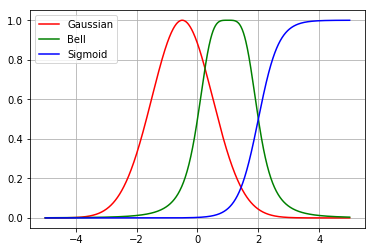

In [5]:
x = np.array(range(-500, 501))/100
gau = gaussmf(x=x, mean=-0.5, sigma=1)
bell = gbellmf(x=x, a=1, b=2, c=1)
sig = sigmf(x=x, b=2, c=3)

plt.plot(x, gau, 'r', label='Gaussian')
plt.plot(x, bell, 'g', label='Bell')
plt.plot(x, sig, 'b', label='Sigmoid')
plt.grid(True)
plt.legend()

## Membership function class

In [6]:
# -*- coding: utf-8 -*-
"""
Created on Mon Mar 31 15:41:58 2014

@author: tim.meggs
"""

# from skfuzzy import gaussmf, gbellmf, sigmf

class MemFuncs:
    """Common base class for all employees"""
    
    funcDict = {'gaussmf': gaussmf, 'gbellmf': gbellmf, 'sigmf': sigmf}

    def __init__(self, MFList):
        self.MFList = MFList

    def evaluateMF(self, rowInput):
        if len(rowInput) != len(self.MFList):
            print("Number of variables does not match number of rule sets")
            
        return np.array([
            [
                self.funcDict[
                    self.MFList[i][k][0]
                ](rowInput[i],**self.MFList[i][k][1]) 
                for k in range(len(self.MFList[i]))
            ] 
            for i in range(len(rowInput))
        ])

In [7]:
# evaluateMF test
# Membership funciton for 2-D variable

MFList = [
    [
        ['gaussmf', {'mean':0.,'sigma':1.}],
        ['gaussmf', {'mean':-1.,'sigma':2.}],
        ['gaussmf', {'mean':-4.,'sigma':10.}],
        ['gaussmf', {'mean':-7.,'sigma':7.}]
    ],
    [
        ['gaussmf', {'mean':1.,'sigma':2.}],
        ['gaussmf', {'mean':2.,'sigma':3.}],
        ['gaussmf', {'mean':-2.,'sigma':10.}],
        ['gaussmf', {'mean':-10.5,'sigma':5.}]
    ]
]

mfca = MemFuncs(MFList)
var_test = np.array([[2, 3, 4, 5],
                     [3, 4, 5, 6]])

mfca.evaluateMF(var_test)

array([[[1.35335283e-01, 1.11089965e-02, 3.35462628e-04, 3.72665317e-06],
        [3.24652467e-01, 1.35335283e-01, 4.39369336e-02, 1.11089965e-02],
        [8.35270211e-01, 7.82704538e-01, 7.26149037e-01, 6.66976811e-01],
        [4.37564738e-01, 3.60447789e-01, 2.90923807e-01, 2.30066299e-01]],

       [[6.06530660e-01, 3.24652467e-01, 1.35335283e-01, 4.39369336e-02],
        [9.45959469e-01, 8.00737403e-01, 6.06530660e-01, 4.11112291e-01],
        [8.82496903e-01, 8.35270211e-01, 7.82704538e-01, 7.26149037e-01],
        [2.61214099e-02, 1.49207861e-02, 8.18870101e-03, 4.31784001e-03]]])

## Membership function derivatives

In [8]:
def dgaussmfMean(x, mean, sigma):
    """
    Derivative gaussian membership function by mean
    np.exp(-((x - mean)**2.) / (2 * sigma**2.))
    """
    return (1./sigma**2) *(x-mean) * gaussmf(x, mean, sigma)
 

def dgaussmfSigma(x, mean, sigma):
    """
    Derivative gaussian membership function by sigma
    """
    return (1./sigma**3) * (x-mean)**2 * gaussmf(x, mean, sigma)


def dgbellmfA(x, a, b, c):
    """
    Derivative bell membership function by a
    """
    return gbellmf(x,a,b,c)*(1-gbellmf(x,a,b,c))*2.*b/a


def dgbellmfB(x, a, b, c):
    """
    Derivative bell membership function by b
    """
    return -2*gbellmf(x, a, b, c)*(1-gbellmf(x, a, b, c))*np.log(np.abs((x-c)/a)) 
                

def dgbellmfC(x, a, b, c):
    """
    Derivative bell membership function by c
    """
    return -2.*b/(c-x) * gbellmf(x, a, b, c)*(1-gbellmf(x, a, b, c))


def dsigmfB(x, b, c):
    """
    Derivative sigmoid membership function by b
    1. / (1. + np.exp(- c * (x - b)))
    
    """
    return -c * (1-sigmf(x, b, c)) * sigmf(x, b, c)
    
    
def dsigmfC(x, b, c):
    """
    Derivative sigmoid membership function by c
    """
    return (x - b) * (1-sigmf(x, b, c)) * sigmf(x, b, c)

In [9]:
def partial_dMF(x, mf_definition, partial_parameter):
    """
    Calculates the partial derivative of a membership function at a point x.
    This is for back-propagation over parameter
    Parameters
    x: input variable
    mf_definition: membership funtion definition, e.g.: ['gaussmf', {'mean':0.,'sigma':1.}]
    partial_parameter: parameter to gte derivative
    ------
    Returns
    derivative of membership function by parameter
    ------
    """
    result = 0
    # get function name
    mf_name = mf_definition[0]
    

    if mf_name == 'gaussmf':
        # get parameters
        sigma = mf_definition[1]['sigma']
        mean = mf_definition[1]['mean']
        # calculate derivatives
        if partial_parameter == 'sigma':   # dMf/dSigma
            result = dgaussmfSigma(x, mean, sigma)
        elif partial_parameter == 'mean':  # dMf/dMean
            result = dgaussmfMean(x, mean, sigma)

    elif mf_name == 'gbellmf':
        # get parameters
        a = mf_definition[1]['a']
        b = mf_definition[1]['b']
        c = mf_definition[1]['c']
        # calculate derivatives
        if partial_parameter == 'a':    # dMf/da
            result = dgbellmfA(x, a, b, c)
        elif partial_parameter == 'b':  # dMf/db
            result = dgbellmfB(x, a, b, c)
        elif partial_parameter == 'c':  # dMf/dc 
            result = dgbellmfC(x, a, b, c)

    elif mf_name == 'sigmf':
        # get parameters
        b = mf_definition[1]['b']
        c = mf_definition[1]['c']
        # calculate derivatives
        if partial_parameter == 'b':    # dMf/db
            result = dsigmfB(x, b, c)
        elif partial_parameter == 'c':  # dMf/dc
            result = dsigmfC(x, b, c)

    return result

### Test derivatives
#### Gausian

In [10]:
funDict = {'gaussmf': gaussmf, 'gbellmf': gbellmf, 'sigmf': sigmf}
mfdef = ['gaussmf', {'mean':0.,'sigma':1.}]
xtest = 0.5
eps = 0.001
ets_der = (funDict[mfdef[0]](xtest, mfdef[1]['mean']+eps, mfdef[1]['sigma'])\
           -funDict[mfdef[0]](xtest, mfdef[1]['mean']-eps, mfdef[1]['sigma']))/(2*eps)
ets_cal = partial_dMF(xtest, mfdef, 'mean')

print("Mean's difference:", ets_der - ets_cal)

ets_der = (funDict[mfdef[0]](xtest, mfdef[1]['mean'], mfdef[1]['sigma']+eps)\
           -funDict[mfdef[0]](xtest, mfdef[1]['mean'], mfdef[1]['sigma']-eps))/(2*eps)
ets_cal = partial_dMF(xtest, mfdef, 'sigma')
print("Sigma's difference:", ets_der - ets_cal)

Mean's difference: -2.022388480016346e-07
Sigma's difference: 3.608129017229622e-07


#### Bell function

In [11]:
mfdef = ['gbellmf', {'a': -1.5,'b': 2, 'c': -2.}]
xtest = 0.5
eps = 0.01

ets_der = (funDict[mfdef[0]](xtest, mfdef[1]['a']+eps, mfdef[1]['b'], mfdef[1]['c']) - \
          funDict[mfdef[0]](xtest, mfdef[1]['a']-eps, mfdef[1]['b'], mfdef[1]['c']))\
          /(2*eps)
ets_cal = partial_dMF(xtest, mfdef, 'a')

print("a's difference:", ets_der - ets_cal)

ets_der = (funDict[mfdef[0]](xtest, mfdef[1]['a'], mfdef[1]['b']+eps, mfdef[1]['c']) - \
          funDict[mfdef[0]](xtest, mfdef[1]['a'], mfdef[1]['b']-eps, mfdef[1]['c']))\
          /(2*eps)
ets_cal = partial_dMF(xtest, mfdef, 'b')

print("b's difference:", ets_der - ets_cal)

ets_der = (funDict[mfdef[0]](xtest, mfdef[1]['a'], mfdef[1]['b'], mfdef[1]['c']+eps) - \
          funDict[mfdef[0]](xtest, mfdef[1]['a'], mfdef[1]['b'], mfdef[1]['c']-eps))\
          /(2*eps)
ets_cal = partial_dMF(xtest, mfdef, 'c')

print("c's difference:", ets_der - ets_cal)

a's difference: 2.0002207765656976e-06
b's difference: -7.050712671347048e-07
c's difference: 7.5819991969539036e-06


#### Sigmoid function

In [12]:
mfdef = ['sigmf', {'b': 1, 'c': 2.}]
xtest = 0.6
eps = 0.001

ets_der = (funDict[mfdef[0]](xtest, mfdef[1]['b']+eps, mfdef[1]['c']) - \
          funDict[mfdef[0]](xtest, mfdef[1]['b']-eps, mfdef[1]['c']))\
          /(2*eps)
ets_cal = partial_dMF(xtest, mfdef, 'b')

print("b's difference:", ets_der - ets_cal)

ets_der = (funDict[mfdef[0]](xtest, mfdef[1]['b'], mfdef[1]['c']+eps) - \
          funDict[mfdef[0]](xtest, mfdef[1]['b'], mfdef[1]['c']-eps))\
          /(2*eps)
ets_cal = partial_dMF(xtest, mfdef, 'c')

print("c's difference:", ets_der - ets_cal)

b's difference: 8.084596164747992e-08
c's difference: 6.467923002739795e-10


## ANFIS class implement

In [13]:
def LSE(A, B, initialGamma = 1000.):
    """
    Use least squared estimation to find LSE(A,B) that
    A.dot(LSE(A, B)) ~ B
    """
    
    coeffMat = np.array(A)
    rhsMat = np.array(B)

    S = np.eye(coeffMat.shape[1])*initialGamma
    x = np.zeros((coeffMat.shape[1], 1))
    
    for i in range(coeffMat.shape[0]):
        a = np.matrix(coeffMat[i])
        b = np.matrix(rhsMat[i])
        S = S - S.dot(a.T).dot(a).dot(S)/(1+a.dot(S).dot(a.T))
        x = x + S.dot(a.T).dot(b-a.dot(x))
    return x

In [59]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr 03 07:30:34 2014
@author: tim.meggs
"""

class ANFIS:
    """Class to implement an Adaptive Network Fuzzy Inference System: ANFIS"

    Attributes:
        X - input
        Y - output
        XLen - input len
        memClass - membership function object
        memFuncs - membership function list
        memFuncsByVariable - membership function by variable
        
        rules - fuzzy rules
            if x1 gets value from [x11, x12]
               x2 gets value from [x21, x22]
            then rule 'x1 = x11 & x2 = x21' equivalent (0,0) and so on.  
               
        consequents - layerFour.dot(consequents) = layerFive
        errors - sum square(real values - predicted values)
        memFuncsHomo - true if there's the same number of membership functions 
        for all variables
            example
                if memFuncs = [[['gaussmf',...],['gaussmf', ...]],
                               [['gaussmf', ...],['gaussmf', ...]]]
                then memFuncsHomo = True (2 membership functions for each)
        trainingType - 'Not trained yet'/'trainHybridJangOffLine'
    """

    def __init__(self, X, Y, memFunction):
        """
        Initialise ANFIS instance from
        - input X = [[val1, val2, ...], [...]]
        - output Y [...]
        - membership function object memFunction [see: class MemFuncs]
        X.shape[0] - number of training sample
        X.shape[1] - number of inputs in fuzzy neural net
        """
        self.X = np.array(copy.copy(X))
        self.Y = np.array(copy.copy(Y))
        self.XLen = len(self.X)
        
        self.memClass = copy.deepcopy(memFunction)
        self.memFuncs = self.memClass.MFList
        
        # indexing membership function 
        self.memFuncsByVariable = [
            [x for x in range(len(self.memFuncs[z]))]
            for z in range(len(self.memFuncs))
        ]
        
        # list of possible rules = 
        # number of membership fuctions for 1st variable *
        # number of membership fuctions for 2nd variable ...
        self.rules = np.array(list(itertools.product(*self.memFuncsByVariable)))
        
        self.consequents = \
        np.zeros(self.Y.ndim * len(self.rules) * (self.X.shape[1] + 1))
        self.errors = np.empty(0)
        
        self.memFuncsHomo = all(
            len(i)==len(self.memFuncsByVariable[0]) 
            for i in self.memFuncsByVariable
        )
        
        self.trainingType = 'Not trained yet'

    def trainHybridJangOffLine(self, epochs=5, tolerance=1e-5, initialGamma=1000, k=0.01):
        """
        Training fuzzy neural network (update parameters of membership functions)
        epochs: number of epochs
        tolerance: tolerance to stop updating parameters 
        initialGamma: used to find LSE(A, B)
        k: learning rate
        Return predicted values
        """

        self.trainingType = 'trainHybridJangOffLine'
        convergence = False
        epoch = 1

        while (epoch < epochs) and (convergence is not True):

            #layer four: forward pass
            [layerFour, wSum, w] = self.forwardHalfPass(self.X)

            #layer five: least squares estimate
            layerFive = np.array(LSE(layerFour,self.Y,initialGamma))
            self.consequents = layerFive
            
            # layer five, final forward pass
            layerFive = layerFour.dot(layerFive)

            # error - RMSE
            error = np.sum((self.Y-layerFive.T)**2)/self.Y.shape[0]
            error = np.sqrt(error)
            print('current error: ', error)
            # MAE
            # average_error = np.average(np.absolute(self.Y-layerFive.T))
            self.errors = np.append(self.errors,error)

            if len(self.errors) != 0:
                if self.errors[len(self.errors)-1] < tolerance:
                    convergence = True

            # back propagation
            if convergence is not True:
                cols = range(self.X.shape[1])
                dE_dAlpha = list(self.backprop(colX, cols, wSum, w, layerFive) 
                                 for colX in range(self.X.shape[1]))


            if len(self.errors) >= 4:
                if (self.errors[-4] > self.errors[-3] > \
                    self.errors[-2] > self.errors[-1]):
                    k = k * 1.1

            if len(self.errors) >= 5:
                if (self.errors[-1] < self.errors[-2]) \
                   and (self.errors[-3] < self.errors[-2]) \
                   and (self.errors[-3] < self.errors[-4]) \
                   and (self.errors[-5] > self.errors[-4]):
                    k = k * 0.9

            # handling of variables with a different number of MFs
            t = []
            for x in range(len(dE_dAlpha)):
                for y in range(len(dE_dAlpha[x])):
                    for z in range(len(dE_dAlpha[x][y])):
                        t.append(dE_dAlpha[x][y][z])

            eta = k / np.abs(np.sum(t))  # learning rate

            if(np.isinf(eta)):
                eta = k

            ## handling of variables with a different number of MFs
            dAlpha = copy.deepcopy(dE_dAlpha)
            if not(self.memFuncsHomo):
                for x in range(len(dE_dAlpha)):
                    for y in range(len(dE_dAlpha[x])):
                        for z in range(len(dE_dAlpha[x][y])):
                            dAlpha[x][y][z] = -eta * dE_dAlpha[x][y][z]
            else:
                dAlpha = -eta * np.array(dE_dAlpha)

            # update parameters
            for varsWithMemFuncs in range(len(self.memFuncs)):
                for MFs in range(len(self.memFuncsByVariable[varsWithMemFuncs])):
                    paramList = sorted(self.memFuncs[varsWithMemFuncs][MFs][1])
                    for param in range(len(paramList)):
                        self.memFuncs[varsWithMemFuncs][MFs][1][paramList[param]] \
                        = self.memFuncs[varsWithMemFuncs][MFs][1][paramList[param]] \
                        + dAlpha[varsWithMemFuncs][MFs][param]
            epoch = epoch + 1


        self.fittedValues = self.predict(self.X)
        self.residuals = self.Y - self.fittedValues[:,0]

        return self.fittedValues

    def plotErrors(self):
        """
        Show training error vs epoch number
        """
        if self.trainingType == 'Not trained yet':
            print(self.trainingType)
        else:
            plt.plot(range(len(self.errors)),self.errors,'ro', label='errors')
            plt.ylabel('error')
            plt.xlabel('epoch')
            plt.show()

    def plotMF(self, x, inputVar):
        """
        Plot graph of membership function
        x: 1-D array
        inputVar: index of variable, of which we take membership functions
        """
        for mf in range(len(self.memFuncs[inputVar])):
            if self.memFuncs[inputVar][mf][0] == 'gaussmf':
                y = gaussmf(x,**self.memClass.MFList[inputVar][mf][1])
            elif self.memFuncs[inputVar][mf][0] == 'gbellmf':
                y = gbellmf(x,**self.memClass.MFList[inputVar][mf][1])
            elif self.memFuncs[inputVar][mf][0] == 'sigmf':
                y = sigmf(x,**self.memClass.MFList[inputVar][mf][1])
            plt.plot(x,y,'r')

        plt.show()

    def plotResults(self):
        """
        Plot predicted values vs true values
        only for 1-D true values
        """
        if self.trainingType == 'Not trained yet':
            print(self.trainingType)
        else:
            plt.plot(range(len(self.fittedValues)),
                     self.fittedValues,'r', 
                     label='trained')
            plt.plot(range(len(self.Y)),self.Y,'b', label='original')
            plt.legend(loc='upper left')
            plt.show()
            
            
    def forwardHalfPass(self, Xs):
        """
        Fuzzy neural network forward propagation from Xs (half pass)
        return layerFour (not the last layer),
               w and wSum: weight and sum weight for each example
               these are for backprop
        """
        layerFour = np.empty(0,)
        wSum = []

        for pattern in range(Xs.shape[0]):
            # layer one
            layerOne = self.memClass.evaluateMF(Xs[pattern,:])

            # layer two
            miAlloc = [
                [
                    layerOne[x][self.rules[row][x]]
                    for x in range(len(self.rules[0]))
                ] 
                for row in range(len(self.rules))
            ]  # values of membership functions
            layerTwo = np.array([np.product(x) 
                                 for x in miAlloc]).T
            if pattern == 0:  # in case ONE input
                w = layerTwo
            else:
                w = np.vstack((w,layerTwo))

            # layer three
            wSum.append(np.sum(layerTwo))
            layerThree = layerTwo/wSum[pattern]
            
            if pattern == 0:
                wNormalized = layerTwo/wSum[pattern]
            else:
                wNormalized = np.vstack((wNormalized,layerTwo/wSum[pattern]))

            # prep for layer four (bit of a hack)
            # add 1-column (bias) then append to layerFour
            rowHolder = np.concatenate([x*np.append(Xs[pattern,:],1) 
                                        for x in layerThree])
            layerFour = np.append(layerFour,rowHolder)

        # layer four
        layerFour = np.array(np.array_split(layerFour,pattern + 1))

        return layerFour, wSum, w.T

    def backprop(self, columnX, columns, theWSum, theW, theLayerFive):
        
        """
        back propagation for fuzzy neural network
        columnX: column in input matrix self.X
        columns: list of column indices of self.X
        theWSum: sum of weights in forward half pass
        theW: weights in forward half pass
        theLayerFive: predicted value by FANN
        
        Return steps to update parameters in membership function list
        """

        paramGrp = [0]* len(self.memFuncs[columnX])
        for MF in range(len(self.memFuncs[columnX])):   
            # for each membership function of columnX-th variable
            
            # get number of parameters
            parameters = np.empty(len(self.memFuncs[columnX][MF][1]))
            timesThru = 0
            
            for alpha in sorted(self.memFuncs[columnX][MF][1].keys()):
                # for each parameter of membership function
                
                bucket3 = np.empty(len(self.X))
                for rowX in range(len(self.X)):
                    # for each sample
                    
                    # get value of variable (x)
                    varToTest = self.X[rowX,columnX]   # x
                    tmpRow = np.empty(len(self.memFuncs))
                    tmpRow.fill(varToTest)

                    bucket2 = np.empty(self.Y.ndim)
                    for colY in range(self.Y.ndim):

                        rulesWithAlpha = np.array(
                            np.where(self.rules[:,columnX]==MF)
                        )[0]
                        adjCols = np.delete(columns,columnX)

                        # get derivative of selected parameter alpha
                        senSit = partial_dMF(
                            x=self.X[rowX,columnX],
                            mf_definition=self.memFuncs[columnX][MF],
                            partial_parameter=alpha
                        )
                        
                        # produces d_ruleOutput/d_parameterWithinMF
                        dW_dAplha = senSit * \
                        np.array(
                            [np.prod(
                              [self.memClass.evaluateMF(tmpRow)[c][self.rules[r][c]]
                              for c in adjCols]
                            ) 
                            for r in rulesWithAlpha]
                        )

                        bucket1 = np.empty(self.rules.shape[0])
                        for consequent in range(self.rules.shape[0]):
                            # for each rule
                            fConsequent = np.append(self.X[rowX,:],1.)\
                                            .dot(
                                self.consequents[
                                    ((self.X.shape[1] + 1) * consequent):
                                    ((self.X.shape[1] + 1) * (consequent + 1)),
                                    colY]
                            )
                            
                            acum = 0
                            if consequent in rulesWithAlpha:
                                acum = dW_dAplha[np.where(rulesWithAlpha==consequent)] \
                                * theWSum[rowX]

                            acum = acum - theW[consequent,rowX] * np.sum(dW_dAplha)
                            acum = acum / theWSum[rowX]**2
                            bucket1[consequent] = fConsequent * acum

                        sum1 = np.sum(bucket1)

                        if self.Y.ndim == 1:
                            bucket2[colY] = \
                            sum1 * (self.Y[rowX]-theLayerFive[rowX,colY])*(2)
                        else:
                            bucket2[colY] = \
                            sum1 * (self.Y[rowX,colY]-theLayerFive[rowX,colY])*(2)

                    sum2 = np.sum(bucket2)
                    bucket3[rowX] = sum2

                sum3 = np.sum(bucket3)
                parameters[timesThru] = sum3
                timesThru = timesThru + 1

            paramGrp[MF] = parameters

        return paramGrp


    def predict(self, varsToTest):
        """
        Calculate predicted value for varsToTest
        The number of columns in varsToTest must equal len(self.MFList)
        """
        [layerFour, wSum, w] = self.forwardHalfPass(varsToTest)

        #layer five
        layerFive = layerFour.dot(self.consequents)

        return layerFive

In [19]:
# import membership
# import anfis
# import membership #import membershipfunction, mfDerivs
import numpy


ts = numpy.loadtxt("/home/hung/githubtest/anfis/anfistest/trainingSet.txt", usecols=[1,2,3])#numpy.loadtxt('c:\\Python_fiddling\\myProject\\MF\\trainingSet.txt',usecols=[1,2,3])
X = ts[:,0:2]
Y = ts[:,2]

mf = \
[
    [
        ['gaussmf', {'mean':0.,'sigma':1.}],
        ['gaussmf', {'mean':-1.,'sigma':2.}],
        ['gaussmf', {'mean':-4.,'sigma':10.}],
        ['gaussmf', {'mean':-7.,'sigma':7.}]
    ],
    [
        ['gaussmf', {'mean':1.,'sigma':2.}],
        ['gaussmf', {'mean':2.,'sigma':3.}],
        ['gaussmf', {'mean':-2.,'sigma':10.}],
        ['gaussmf', {'mean':-10.5,'sigma':5.}]
    ]
]

In [62]:
anf.memFuncs

[[['gaussmf', {'mean': -0.10179690334209203, 'sigma': 0.6370345095656053}],
  ['gaussmf', {'mean': -1.0472297259913361, 'sigma': 1.846603513128207}],
  ['gaussmf', {'mean': -3.9852445493597966, 'sigma': 10.001479045808813}],
  ['gaussmf', {'mean': -6.96113242566216, 'sigma': 7.028769581842266}]],
 [['gaussmf', {'mean': 0.7736264529141742, 'sigma': 1.5759783885974663}],
  ['gaussmf', {'mean': 2.100670857091692, 'sigma': 2.9795613727157058}],
  ['gaussmf', {'mean': -2.0031881019227047, 'sigma': 9.998073551486968}],
  ['gaussmf', {'mean': -10.48959491439451, 'sigma': 5.023300484638299}]]]

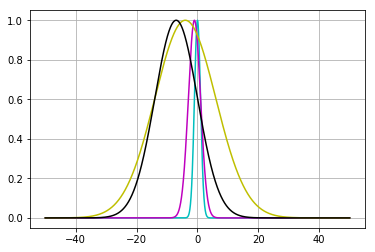

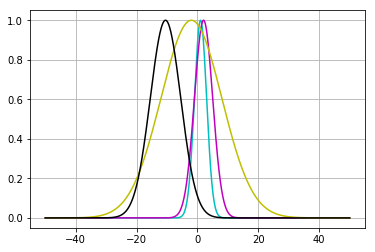

In [53]:
# initial mf plot
xx = np.array(range(-5000, 5001))/100
yy = np.zeros((2,4,xx.shape[0]))
color = ['c', 'm', 'y', 'k']
for i in range(2):
    plt.figure()
    for j in range(4):
        mean = mf[i][j][1]['mean']
        sigma = mf[i][j][1]['sigma']
        yy[i,j,:] = gaussmf(xx, mean, sigma)
        plt.plot(xx, yy[i][j], color[j])
    plt.grid(True)

current error:  0.05158410698469028
current error:  0.05140008371242771
current error:  0.051246087727819224
current error:  0.05111703732917551
current error:  0.05099852697554464
current error:  0.05089188817402644
current error:  0.05079832338658199
current error:  0.05071886934843473
current error:  0.0506543566913703
current error:  0.050605365202283405
current error:  0.05057217457844877
current error:  0.05055471142247352
current error:  0.050552494307185426
current error:  0.050564579544157384
current error:  0.05058669904903323
current error:  0.05061483067816691
current error:  0.05064602431161662
current error:  0.05067808861399679
current error:  0.050709374231052
current error:  0.050738621994466125
current error:  0.05076485740798626
current error:  0.05078731898235633
current error:  0.05080541106528149
current error:  0.05081867354187358
current error:  0.050826762157001576
current error:  0.050829434612328715
current error:  0.05082653903859128
current error:  0.050818

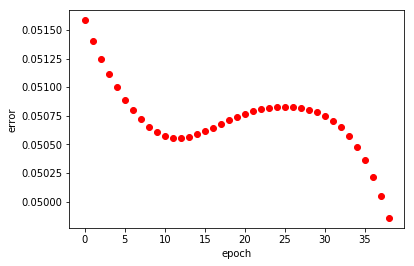

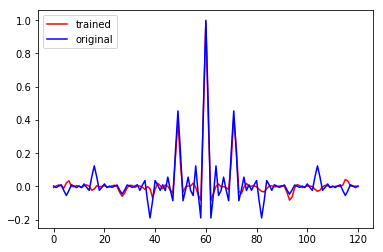

In [60]:
mfc = MemFuncs(mf)
anf = ANFIS(X, Y, mfc)
anf.trainHybridJangOffLine(epochs=40, k=0.01)
# print(round(anf.consequents[-1][0],6))
# print(round(anf.consequents[-2][0],6))
# print(round(anf.fittedValues[9][0],6))
if round(anf.consequents[-1][0],6) == -5.275538 and round(anf.consequents[-2][0],6) == -1.990703 and round(anf.fittedValues[9][0],6) == 0.002249:
    print('test is good')
anf.plotErrors()
anf.plotResults()

In [23]:
mfc.evaluateMF(np.array([[1],[2]]))

array([[[0.60653066],
        [0.60653066],
        [0.8824969 ],
        [0.52045012]],

       [[0.8824969 ],
        [1.        ],
        [0.92311635],
        [0.04393693]]])

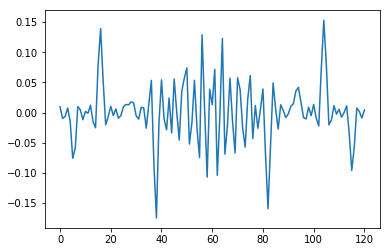

In [61]:
plt.plot((Y-np.squeeze(anf.predict(X))))

In [66]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(np.matrix(Y).transpose(), anf.predict(X)))

0.049640393094560045

Text(0.5,0,'Z-axis')

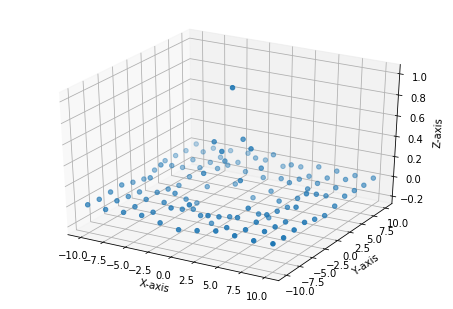

In [26]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(ts[:, 0], ts[:, 1], ts[:, 2], )
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

In [69]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X=X, y=Y)
np.sqrt(mean_squared_error(Y, model.predict(X)))

0.13718523974144253